# An introduction to HRS data reduction

Bo Zhang  <mailto:bozhang@nao.cas.cn>

In this notebook, we describe how to use `hrs` package to reduce HRS data.

To install `hrs` package, type `pip install hrs` in your terminal.


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import ccdproc
import hrs

# from astropy.table import Table, Column, Row
os.chdir('/town/HRS/20161110test')
# %matplotlib 

In [2]:
ls

2016111000100.fits  20161110002.fits   201611100054.fits  201611100079.fits
2016111000101.fits  201611100030.fits  201611100055.fits  20161110007.fits
2016111000103.fits  201611100031.fits  201611100056.fits  201611100081.fits
2016111000104.fits  201611100032.fits  201611100057.fits  201611100082.fits
2016111000105.fits  201611100034.fits  201611100058.fits  201611100083.fits
2016111000106.fits  201611100035.fits  201611100059.fits  201611100084.fits
2016111000107.fits  201611100036.fits  20161110005.fits   201611100085.fits
201611100010.fits   201611100037.fits  201611100060.fits  201611100086.fits
201611100012.fits   201611100038.fits  201611100061.fits  201611100087.fits
201611100013.fits   201611100039.fits  201611100062.fits  201611100088.fits
201611100014.fits   20161110003.fits   201611100063.fits  201611100089.fits
201611100015.fits   201611100040.fits  201611100064.fits  20161110008.fits
201611100016.fits   201611100041.fits  201611100065.fits  201611100090.fits
201611100017.f

## 1. Read log table

In [3]:
logt = hrs.LogTable.read_log('./20161110.txt')

In [6]:
logt.pprint(1000, 1000)

    file      obj    exp_start exp_time      RA         Dec     epoch note      filename     
----------- -------- --------- -------- ----------- ----------- ----- ---- ------------------
20161110001     flat  19:39:54      9.0                                      20161110001.fits
20161110002     flat  19:39:54      9.0                                      20161110002.fits
20161110003     flat  19:39:54      9.0                                      20161110003.fits
20161110004     flat  19:39:54      9.0                                      20161110004.fits
20161110005     flat  19:39:54      9.0                                      20161110005.fits
20161110006     flat  19:39:54      9.0                                      20161110006.fits
20161110007     flat  19:39:54      9.0                                      20161110007.fits
20161110008     flat  19:39:54      9.0                                      20161110008.fits
20161110009     flat  19:39:54      9.0                     

## 2. Process BIAS

In [7]:
ind_bias = logt['obj']=='bias'
bias = ccdproc.combine(','.join(logt['filename'][ind_bias]), unit='adu', method='median')

INFO: splitting each image into 1 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]


## 3. Process FLAT

### bias substraction & trim

In [8]:
ind_flat1_1 = (logt['obj']=='flat')*(logt['exp_time']==8)
ind_flat1_2 = (logt['obj']=='flat')*(logt['exp_time']==9)
ind_flat2_1 = (logt['obj']=='flat')*(logt['exp_time']==32)
ind_flat2_2 = (logt['obj']=='flat')*(logt['exp_time']==36)
ind_flat3 = (logt['obj']=='flat')*(logt['exp_time']==144)

flat1_1 = ccdproc.combine(','.join(logt['filename'][ind_flat1_1]), unit='adu', method='median')
flat1_2 = ccdproc.combine(','.join(logt['filename'][ind_flat1_2]), unit='adu', method='median')
flat2_1 = ccdproc.combine(','.join(logt['filename'][ind_flat2_1]), unit='adu', method='median')
flat2_2 = ccdproc.combine(','.join(logt['filename'][ind_flat2_2]), unit='adu', method='median')
flat3 = ccdproc.combine(','.join(logt['filename'][ind_flat3]), unit='adu', method='median')
flat1 = ccdproc.combine([flat1_1.multiply(9.).divide(8.), flat1_2], method='average')
flat2 = ccdproc.combine([flat2_1.multiply(36.).divide(32.), flat2_2], method='average')

flat1_bias = ccdproc.subtract_bias(flat1, bias)
flat2_bias = ccdproc.subtract_bias(flat2, bias)
flat3_bias = ccdproc.subtract_bias(flat3, bias)

flat1_bias_trim = ccdproc.trim_image(flat1_bias[:, :4096])
flat2_bias_trim = ccdproc.trim_image(flat2_bias[:, :4096])
flat3_bias_trim = ccdproc.trim_image(flat3_bias[:, :4096])

INFO: splitting each image into 1 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]
INFO: splitting each image into 1 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]
INFO: splitting each image into 1 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]
INFO: splitting each image into 1 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]
INFO: splitting each image into 1 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]
INFO: splitting each image into 1 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]
INFO: splitting each image into 1 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]


### combine FLAT

In [10]:
flat_list = [flat1_bias_trim, flat2_bias_trim, flat3_bias_trim]

# find & combine & group apertures
ap_comb = hrs.combine_apertures(flat_list, n_jobs=10)
cheb_coefs, ap_uorder_interp = hrs.group_apertures(ap_comb, start_col=2100, order_dist=10)

# combine flat
flat_comb, flat_origin = hrs.combine_flat(flat_list, ap_uorder_interp, sat_count=45000, p=95)
flat_comb = ccdproc.CCDData(flat_comb, unit='adu')

# scattered light substraction
flat_comb_sl = hrs.substract_scattered_light(flat_comb, ap_uorder_interp, ap_width=10, shrink=.85)
flat1d = hrs.extract_1dspec(flat_comb_sl, ap_uorder_interp, ap_width=7)[0]

@Cham: 143 possible apertures found (exciting)!


/usr/local/lib/python2.7/dist-packages/astropy/nddata/mixins/ndslicing.py:87: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  kwargs['data'] = self.data[item]


@Cham: 141 possible apertures found (exciting)!


/usr/local/lib/python2.7/dist-packages/astropy/nddata/mixins/ndslicing.py:87: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  kwargs['data'] = self.data[item]


@Cham: tracing aperture [0] 
@Cham: tracing aperture [1] 
@Cham: 137 possible apertures found (exciting)!


/usr/local/lib/python2.7/dist-packages/astropy/nddata/mixins/ndslicing.py:87: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  kwargs['data'] = self.data[item]


@Cham: tracing aperture [0] 
@Cham: tracing aperture [1] 
@Cham: tracing aperture [2] 
@Cham: tracing aperture [0] 
@Cham: tracing aperture [1] 
@Cham: tracing aperture [2] 
@Cham: tracing aperture [3] 
@Cham: tracing aperture [2] 
@Cham: tracing aperture [3] 
@Cham: tracing aperture [4] 
@Cham: tracing aperture [3] 
@Cham: tracing aperture [4] 
@Cham: tracing aperture [5] 
@Cham: tracing aperture [6] 
@Cham: tracing aperture [7] 
@Cham: tracing aperture [8] 
@Cham: tracing aperture [9] 
@Cham: tracing aperture [10] 
@Cham: tracing aperture [11] 
@Cham: tracing aperture [12] 
@Cham: tracing aperture [13] 
@Cham: tracing aperture [14] 
@Cham: tracing aperture [15] 
@Cham: tracing aperture [16] 
@Cham: tracing aperture [17] 
@Cham: tracing aperture [18] 
@Cham: tracing aperture [19] 
@Cham: tracing aperture [20] 
@Cham: tracing aperture [21] 
@Cham: tracing aperture [22] 
@Cham: tracing aperture [23] 
@Cham: tracing aperture [24] 
@Cham: tracing aperture [25] 
@Cham: tracing aperture [26

[Parallel(n_jobs=10)]: Done   3 out of   3 | elapsed:  1.1min finished


('@Cham: the numbers of apertures found are: ', [99, 84, 61])
@Cham: 104 unique orders found!
@Cham: marking pixels of order [0]
@Cham: marking pixels of order [1]
@Cham: marking pixels of order [2]
@Cham: marking pixels of order [3]
@Cham: marking pixels of order [4]
@Cham: marking pixels of order [5]
@Cham: marking pixels of order [6]
@Cham: marking pixels of order [7]
@Cham: marking pixels of order [8]
@Cham: marking pixels of order [9]
@Cham: marking pixels of order [10]
@Cham: marking pixels of order [11]
@Cham: marking pixels of order [12]
@Cham: marking pixels of order [13]
@Cham: marking pixels of order [14]
@Cham: marking pixels of order [15]
@Cham: marking pixels of order [16]
@Cham: marking pixels of order [17]
@Cham: marking pixels of order [18]
@Cham: marking pixels of order [19]
@Cham: marking pixels of order [20]
@Cham: marking pixels of order [21]
@Cham: marking pixels of order [22]
@Cham: marking pixels of order [23]
@Cham: marking pixels of order [24]
@Cham: marking p

## 4. Process ThAr

### bias substraction

In [11]:
ind_thar1 = (logt['obj']=='thar')*(logt['exp_time']==30)
ind_thar2 = (logt['obj']=='thar')*(logt['exp_time']==60)
ind_thar3 = (logt['obj']=='thar')*(logt['exp_time']==120)

thar1 = ccdproc.combine(','.join(logt['filename'][ind_thar1]), unit='adu', method='average')
thar2 = ccdproc.combine(','.join(logt['filename'][ind_thar2]), unit='adu', method='average')
thar3 = ccdproc.CCDData.read(','.join(logt['filename'][ind_thar3]), unit='adu', method='average')

thar1_bias = ccdproc.subtract_bias(thar1, bias)
thar2_bias = ccdproc.subtract_bias(thar2, bias)
thar3_bias = ccdproc.subtract_bias(thar3, bias)

thar1_bias_trim = ccdproc.trim_image(thar1_bias[:, :4096])
thar2_bias_trim = ccdproc.trim_image(thar2_bias[:, :4096])
thar3_bias_trim = ccdproc.trim_image(thar3_bias[:, :4096])

INFO: splitting each image into 1 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]
INFO: splitting each image into 1 chunks to limit memory usage to 16000000000.0 bytes. [ccdproc.combiner]


### combine & trim

In [13]:
""" combine thar """
thar_list = [thar1_bias_trim, thar2_bias_trim, thar3_bias_trim]
thar_comb, thar_origin = hrs.combine_flat(thar_list, ap_uorder_interp, sat_count=45000, p=100)
thar_comb = ccdproc.CCDData(thar_comb, unit='adu')

""" extract 1d thar """
#thar_comb_sl = substract_scattered_light(thar_comb, ap_uorder_interp, ap_width=10, shrink=.5)
thar1d = hrs.extract_1dspec(thar_comb, ap_uorder_interp, ap_width=7)[0]
thar1d_scaled = thar1d/flat1d

@Cham: marking pixels of order [0]
@Cham: marking pixels of order [1]
@Cham: marking pixels of order [2]
@Cham: marking pixels of order [3]
@Cham: marking pixels of order [4]
@Cham: marking pixels of order [5]
@Cham: marking pixels of order [6]
@Cham: marking pixels of order [7]
@Cham: marking pixels of order [8]
@Cham: marking pixels of order [9]
@Cham: marking pixels of order [10]
@Cham: marking pixels of order [11]
@Cham: marking pixels of order [12]
@Cham: marking pixels of order [13]
@Cham: marking pixels of order [14]
@Cham: marking pixels of order [15]
@Cham: marking pixels of order [16]
@Cham: marking pixels of order [17]
@Cham: marking pixels of order [18]
@Cham: marking pixels of order [19]
@Cham: marking pixels of order [20]
@Cham: marking pixels of order [21]
@Cham: marking pixels of order [22]
@Cham: marking pixels of order [23]
@Cham: marking pixels of order [24]
@Cham: marking pixels of order [25]
@Cham: marking pixels of order [26]
@Cham: marking pixels of order [27]
@C

## 5. Wavelength calibration

### initial estimation

In [15]:
# laod template thar
thar_temp_path = '/home/cham/PycharmProjects/hrs/hrs/calibration/thar_template/thar_temp_w20160120022t.fits'
wave_temp, thar_temp, order_temp = hrs.load_thar_temp(thar_temp_path)

# fix thar
thar1d_fixed = hrs.fix_thar_sat_neg(thar1d, arm=30, sat_count=500000)
thar_temp_fixed = hrs.fix_thar_sat_neg(thar_temp, arm=30, sat_count=500000)

""" initial estimation of wavelength """
shift, corr2d = hrs.thar_corr2d(thar1d_fixed, thar_temp, ytrim=(30, 70), y_shiftmax = 3, x_shiftmax=20)
print ("@Cham: the shift is ", shift)

wave_init = hrs.interpolate_wavelength_shift(wave_temp, shift, thar_temp, thar1d_fixed)
order_init = hrs.interpolate_order_shift(order_temp, shift, thar1d_fixed)

@Cham: computing 2D cross-correlation...
('@Cham: the shift is ', (array([-2]), array([0])))


### refine wavelength

In [20]:
thar_list = np.loadtxt('/home/cham/PycharmProjects/hrs/hrs/calibration/iraf/thar.dat')
poly_order = (3, 5)

# refine thar positions
lc_coord, lc_order, lc_thar, popt, pcov = hrs.calibration.refine_thar_positions(
        wave_init, order_init, thar1d_fixed, thar_list, n_jobs=20, verbose=10)

# fit grating function    
x_mini_lsq, ind_good_thar, scaler_coord, scaler_order, scaler_ml = hrs.calibration.fit_grating_equation(
    lc_coord, lc_order, lc_thar, popt, pcov, poly_order=(3, 5), max_dev_threshold=1., iter=False)
    
# recover the wavelength (grid)
grid_coord = np.repeat(np.arange(wave_init.shape[1]).reshape(1,-1), 104, axis=0)
grid_order = order_init
wave_fitted =  hrs.calibration.grating_equation_predict(
    grid_coord, grid_order, x_mini_lsq, poly_order, scaler_coord, scaler_order, scaler_ml)

# recover the wavelength (thar)
lc_fitted = hrs.grating_equation_predict(
    lc_coord, lc_order, x_mini_lsq, poly_order, scaler_coord, scaler_order, scaler_ml)
lc_fitted_diff = lc_fitted - lc_thar    

@Cham: refine ThAr positions ...


[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    1.1s
[Parallel(n_jobs=20)]: Done  21 tasks      | elapsed:    1.6s
[Parallel(n_jobs=20)]: Done  32 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done  45 tasks      | elapsed:    4.9s
[Parallel(n_jobs=20)]: Done  58 tasks      | elapsed:    8.2s
[Parallel(n_jobs=20)]: Done  76 out of 104 | elapsed:   12.9s remaining:    4.8s
[Parallel(n_jobs=20)]: Done  87 out of 104 | elapsed:   14.9s remaining:    2.9s
[Parallel(n_jobs=20)]: Done  98 out of 104 | elapsed:   17.0s remaining:    1.0s
[Parallel(n_jobs=20)]: Done 104 out of 104 | elapsed:   17.9s finished


103
102
101
100
99


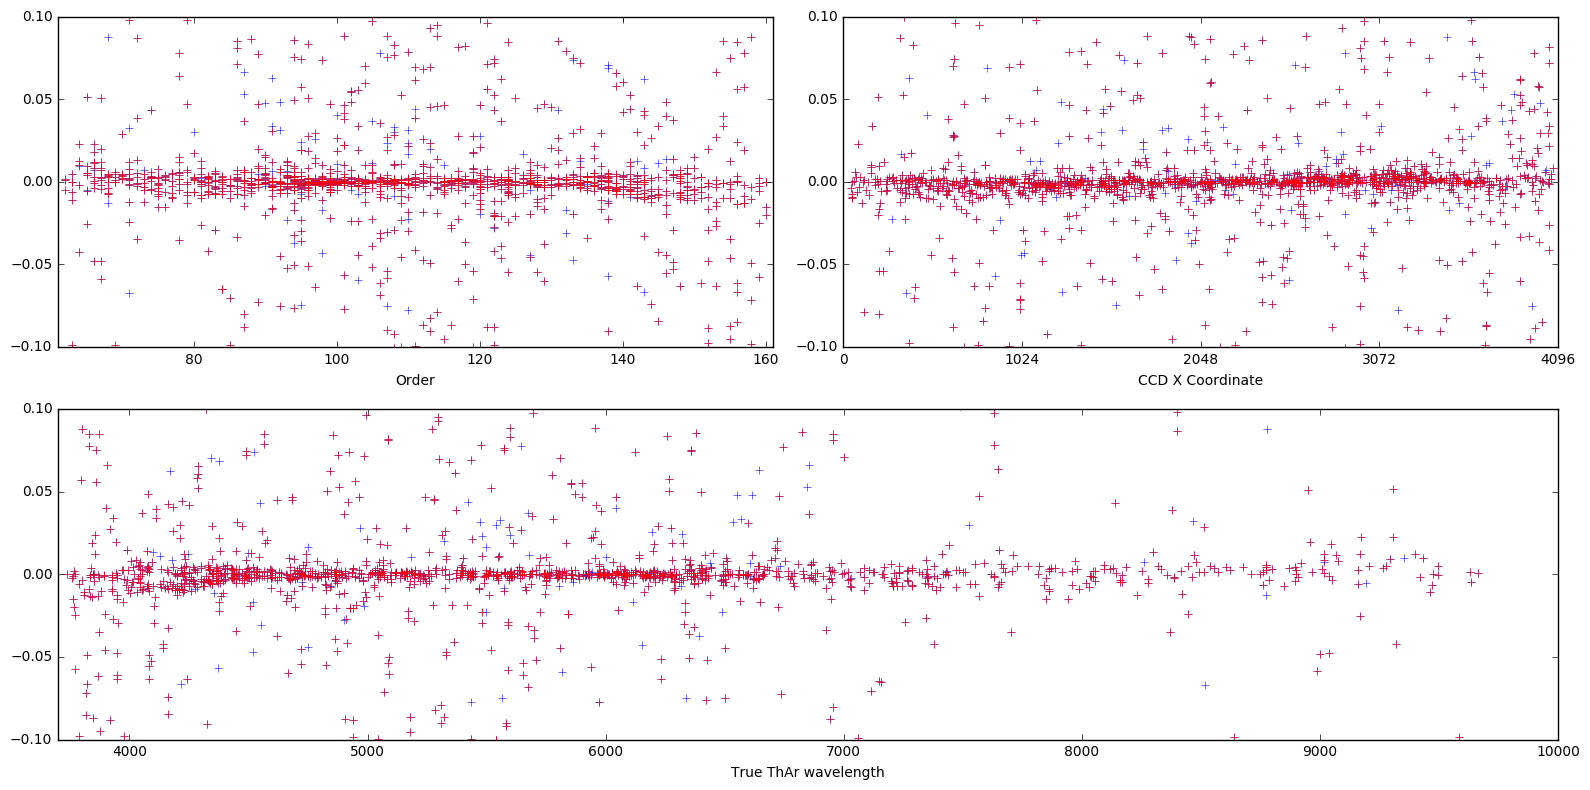

In [25]:
""" residual check zoom in """
%matplotlib inline
fig = plt.figure(figsize=(16,8));
ax = fig.add_subplot(221)
ax.plot(lc_order,lc_fitted-lc_thar, 'b+', alpha=.8)
ax.plot(lc_order[ind_good_thar],lc_fitted[ind_good_thar]-lc_thar[ind_good_thar], 'r+', alpha=.8)
plt.xlabel("Order")
plt.axis([61, 161, -0.1, 0.1])

ax = fig.add_subplot(222)
ax.plot(lc_coord,lc_fitted-lc_thar, 'b+', alpha=.8)
ax.plot(lc_coord[ind_good_thar],lc_fitted[ind_good_thar]-lc_thar[ind_good_thar], 'r+', alpha=.8)
plt.xlabel("CCD X Coordinate")
plt.xticks(np.arange(5)*1024)
plt.axis([0, 4096, -0.1, 0.1])

ax = fig.add_subplot(212)
ax.plot(lc_thar,lc_fitted-lc_thar, 'b+', alpha=.8)
ax.plot(lc_thar[ind_good_thar],lc_fitted[ind_good_thar]-lc_thar[ind_good_thar], 'r+', alpha=.8)
plt.xlabel("True ThAr wavelength")
plt.axis([3700, 10000, -0.1, 0.1])

fig.tight_layout()
fig.show()

## 6. Process Science frames

In [27]:
"""
Master variables:
    bias
    ap_uorder_interp
    flat1d
    wave_fitted
"""

# 1. read
sci = ccdproc.CCDData.read(logt['filename'][41], unit='adu')

# 2. BIAS correction
sci_bias = ccdproc.subtract_bias(sci, bias)

# 3. trim 
sci_bias_trim = ccdproc.trim_image(sci_bias[:, :4096])

# 4. scattered light correction
sci_bias_trim_sl = hrs.substract_scattered_light(sci_bias_trim, ap_uorder_interp, ap_width=10, shrink=.85)

# 5. extract 1D spectra
spec1d = hrs.extract_1dspec(sci_bias_trim_sl, ap_uorder_interp, ap_width=7)[0]

# 6. de-blaze
spec1d_db = spec1d/flat1d

# 7. roughly scale to 1.
spec1d_nm = spec1d_db/np.percentile(spec1d_db, 95, axis=1)[:, None]

@Cham: *find_inter_order* marking pixels of order [0]
@Cham: *find_inter_order* marking pixels of order [1]
@Cham: *find_inter_order* marking pixels of order [2]
@Cham: *find_inter_order* marking pixels of order [3]
@Cham: *find_inter_order* marking pixels of order [4]
@Cham: *find_inter_order* marking pixels of order [5]
@Cham: *find_inter_order* marking pixels of order [6]
@Cham: *find_inter_order* marking pixels of order [7]
@Cham: *find_inter_order* marking pixels of order [8]
@Cham: *find_inter_order* marking pixels of order [9]
@Cham: *find_inter_order* marking pixels of order [10]
@Cham: *find_inter_order* marking pixels of order [11]
@Cham: *find_inter_order* marking pixels of order [12]
@Cham: *find_inter_order* marking pixels of order [13]
@Cham: *find_inter_order* marking pixels of order [14]
@Cham: *find_inter_order* marking pixels of order [15]
@Cham: *find_inter_order* marking pixels of order [16]
@Cham: *find_inter_order* marking pixels of order [17]
@Cham: *find_inter_o

(-0.1, 1.2)

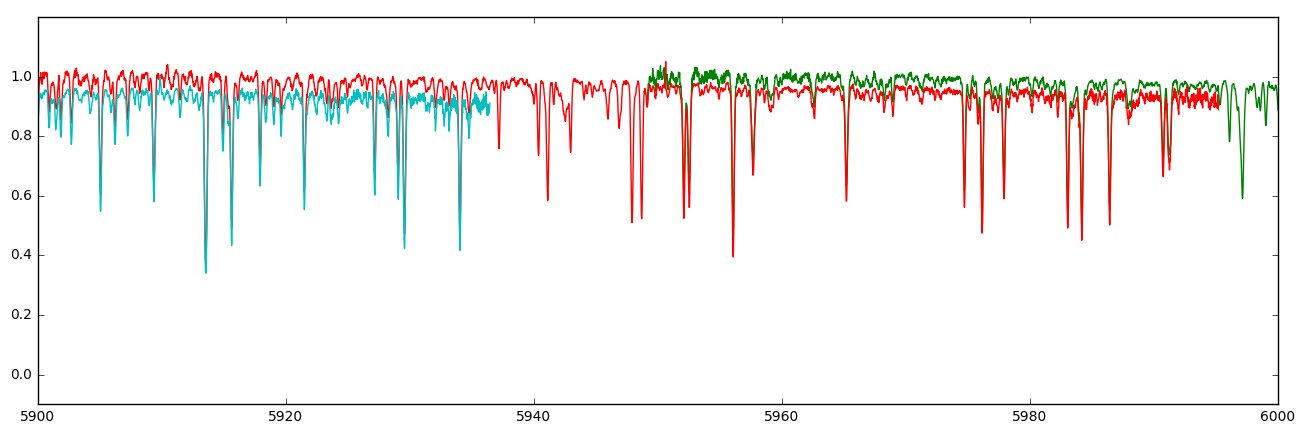

In [32]:
plt.figure(figsize=(16, 5))
plt.plot(wave_fitted.T, spec1d_nm.T);
plt.xlim(5900, 6000)
plt.ylim(-0.1, 1.2)